In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import wandb
import os
from sklearn.decomposition import PCA
import itertools

from collections import Counter

In [2]:
import importlib
import functions as f
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

# Loading Data:
---

In [3]:
file_path = '../data/carls/train_carls.feather'
train_carls = pd.read_feather(file_path)
train_carls = train_carls.drop(columns=['level_0'])

file_path = '../data/carls/val_carls.feather'
val_carls = pd.read_feather(file_path)
val_carls = val_carls.drop(columns=['level_0'])

file_path = '../data/carls/test_carls.feather'
test_carls = pd.read_feather(file_path)
test_carls = test_carls.drop(columns=['level_0'])

In [4]:
# file_path = '../data/MoNA_embeddings_multiple_instrument_types.csv'
# mass_spec_embeddings = pd.read_csv(file_path)
# mass_spec_embeddings = mass_spec_embeddings.rename(columns={
#     'METHYL PROPIONATE': 'Methyl Propionate', 'DIETHYL MALEATE':'Diethyl Maleate'
#     })

# file_path = '../data/mass_spec_encoder_output.csv'
# mass_spec_encoder_generated_embeddings = pd.read_csv(file_path)

In [5]:
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,Background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809719, 0.0005454039, 0.25539753, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318759, 0.009022221, 0.42160067, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520813, 0.009838342, -0.15108328, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106821, 0.0029424396, -0.14450483, 0.0726..."


In [6]:
# file_path = '../data/mass_spec_data_for_kevin_steven.csv'
# mass_spec_encoder_generated_embeddings = pd.read_csv(file_path)

file_path = '../data/mass_spec_name_smiles_embedding_file.csv'
mass_spec_name_smiles_embedding_df = pd.read_csv(file_path)

# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
mass_spec_name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
mass_spec_name_smiles_embedding_df.head()

,SMILES,embedding,Name
Unnamed: 0,,,
"(5R,11R)-5,11-Dimethylpentacosane",CCCCCCCCCCCCCCC(C)CCCCCC(C)CCCC,"[-0.048933726, 0.0017029907, -0.272093, -0.369...","(5R,11R)-5,11-Dimethylpentacosane"
"1,3-Diaminopropane",C(CN)CN,"[-0.22048391, -0.0011410714, 0.06557533, 0.193...","1,3-Diaminopropane"
"1,4-Butanediamine",C(CCN)CN,"[-0.21609126, -0.0005372154, 0.24562673, 0.293...","1,4-Butanediamine"
1-Hexanol,CCCCCCO,"[-0.23157702, 0.0011296304, 0.21073784, -0.179...",1-Hexanol
1-Octanol,CCCCCCCCO,"[-0.2599937, 0.0021180445, 0.109357715, -0.293...",1-Octanol


In [7]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

In [8]:
mass_spec_embedding_floats = []
for chem_name in mass_spec_name_smiles_embedding_df.index:
    embedding_float = mass_spec_name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
    embedding_float = embedding_float.split(']')[0]
    embedding_float = [np.float32(num) for num in embedding_float.split(',')]
    mass_spec_embedding_floats.append(embedding_float)

mass_spec_name_smiles_embedding_df['Embedding Floats'] = mass_spec_embedding_floats

In [9]:
# filtering out chems with < 5 embeddings
# mass_spec_chem_counts = Counter(mass_spec_encoder_generated_embeddings['Label'])
# mass_spec_chem_counts = Counter(mass_spec_encoder_generated_embeddings['chem_name'])
# chems_above_5 = [key for key, count in mass_spec_chem_counts.items() if count >= 5]
filtered_mass_spec_embeddings = pd.DataFrame([emb for emb in mass_spec_name_smiles_embedding_df['Embedding Floats']]).T #mass_spec_embeddings[chems_above_5]
cols = mass_spec_name_smiles_embedding_df.index
filtered_mass_spec_embeddings.columns = cols
# filtered_mass_spec_encoder_generated_embeddings = mass_spec_encoder_generated_embeddings[mass_spec_encoder_generated_embeddings['Label'].isin(chems_above_5)]

# Combine embeddings for IMS simulants and mass spec chems to use for plotting pca
ims_embeddings = pd.DataFrame([emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]).T
cols = name_smiles_embedding_df.index[1:]
ims_embeddings.columns = cols
all_true_embeddings = pd.concat([ims_embeddings, filtered_mass_spec_embeddings], axis=1)
# all_true
all_true_embeddings.head()

Unnamed: 0,DEM,DEB,MES,DMMP,DPM,JP8,TEPO,DtBP,"(5R,11R)-5,11-Dimethylpentacosane","1,3-Diaminopropane",...,Methyl Octadecanoate,Naphthalene,Pentadecane,Phenanthrene,Pyrene,Spermidine,Succinic Acid,Testosterone,Tryptophan,Undecane
0,0.380972,0.063188,-0.325208,0.121068,-0.023968,0.025142,0.193039,0.226090,-0.048934,-0.220484,...,0.169634,0.468407,0.117451,0.579996,0.444973,-0.182377,0.064577,-0.049732,0.188416,0.110121
1,0.000545,0.009022,0.009838,0.002942,0.002720,0.011977,0.000974,0.000808,0.001703,-0.001141,...,0.005854,-0.000690,0.001458,-0.001710,-0.004033,0.002279,0.035474,0.068347,0.001636,0.000952
2,0.255398,0.421601,-0.151083,-0.144505,0.158301,0.542705,0.066288,-0.062160,-0.272093,0.065575,...,-0.123640,0.257259,-0.039999,0.064326,0.064121,0.435218,-0.251742,-0.038517,-0.450764,-0.037651
3,-0.242728,0.195723,0.284503,0.072665,-0.010084,0.364973,-0.195223,-0.045342,-0.369603,0.193559,...,-0.355696,0.331527,-0.441098,0.421061,0.428294,0.452678,0.044983,-0.575486,0.635695,-0.432776
4,-0.305107,-0.167326,-0.099838,-0.107286,-0.067723,-0.236272,-0.272051,-0.075880,-0.023527,-0.015358,...,-0.038613,-0.050993,-0.022548,-0.034104,-0.019335,-0.019928,-0.010587,-0.412169,-0.049434,-0.025410


# Training Encoder on Carls:
---

In [10]:
device = f.set_up_gpu()

Selected GPU ID: 0
  Name: NVIDIA A100-SXM4-80GB
  Memory Free: 81033.0 MB
  Memory Used: 4.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:0
PyTorch current device ID: 0
PyTorch current device name: NVIDIA A100-SXM4-80GB


In [11]:
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_dif_backgrounds.csv'
# train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors_with_dask(file_path, name_smiles_embedding_df, device, carl=True)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_dif_backgrounds.csv'
# val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors_with_dask(file_path, name_smiles_embedding_df, device, carl=True)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_dif_backgrounds.csv'
# test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors_with_dask(file_path, name_smiles_embedding_df, device, carl=True)

In [12]:
train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors(train_carls, name_smiles_embedding_df, device, carl=True)
val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors(val_carls, name_smiles_embedding_df, device, carl=True)
test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors(test_carls, name_smiles_embedding_df, device, carl=True)

In [13]:
sorted_chem_names = list(train_carls.columns[-8:])
del train_carls, val_carls, test_carls

In [14]:
# Things that need to be changed for each encoder/dataset/target embedding
notebook_name = '/home/cmdunham/ChemicalDataGeneration/models/carl_encoder.ipynb'
# notebook_name = 'C:/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/models/carl_encoder.ipynb'
architecture = 'carl_encoder'
dataset_type = 'carls'
target_embedding = 'ChemNet'
encoder_path = 'trained_models/carl_to_chemnet_encoder.pth'

config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = notebook_name

wandb.login(key='9729ad7b1f3a60f1072cdf7af979b737955733d4')

wandb: Currently logged in as: catemerfeld. Use `wandb login --relogin` to force relogin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /home/cmdunham/.netrc


True

In [15]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

wandb: wandb version 0.19.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.17.0


wandb: Run data is saved locally in /home/cmdunham/ChemicalDataGeneration/models/wandb/run-20250204_082411-eu0pxby7
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run cerulean-serenity-584


wandb: ⭐️ View project at https://wandb.ai/catemerfeld/ims_encoder_decoder


wandb: 🚀 View run at https://wandb.ai/catemerfeld/ims_encoder_decoder/runs/eu0pxby7


Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  32
epochs  :  500
learning_rate  :  0.0001


Saved best model at epoch 1
Epoch[1/500]:
   Training loss: 0.0011958303268581828
   Validation loss: 0.0016974992622706534
-------------------------------------------


Saved best model at epoch 3


Saved best model at epoch 4


Saved best model at epoch 5


Saved best model at epoch 7


Epoch[10/500]:
   Training loss: 0.00010858093253356258
   Validation loss: 0.0008591434806398877
-------------------------------------------


Saved best model at epoch 11


Saved best model at epoch 14


Saved best model at epoch 18


Epoch[20/500]:
   Training loss: 0.48483647625163745
   Validation loss: 0.0011678348687394592
-------------------------------------------


Epoch 00024: reducing learning rate of group 0 to 1.0000e-05.


Saved best model at epoch 26


Saved best model at epoch 28


Saved best model at epoch 30
Epoch[30/500]:
   Training loss: 6.78829732068642e-06
   Validation loss: 0.0002840115821069029
-------------------------------------------


Saved best model at epoch 31


Epoch 00037: reducing learning rate of group 0 to 1.0000e-06.


Saved best model at epoch 38


Epoch[40/500]:
   Training loss: 1.2148534343414884e-06
   Validation loss: 0.00027323911701548643
-------------------------------------------


Epoch 00044: reducing learning rate of group 0 to 1.0000e-07.


Epoch 00050: reducing learning rate of group 0 to 1.0000e-08.
Epoch[50/500]:
   Training loss: 5.848454709419737e-07
   Validation loss: 0.0002750415549719297
-------------------------------------------


Validation loss has not improved in 15 epochs. Stopping training at epoch 54.


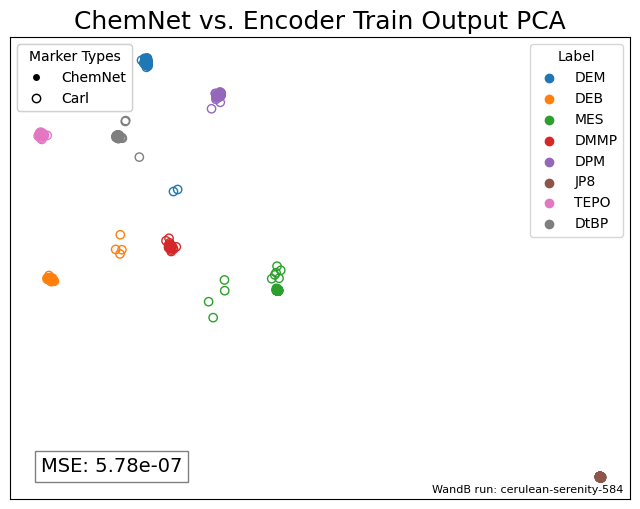

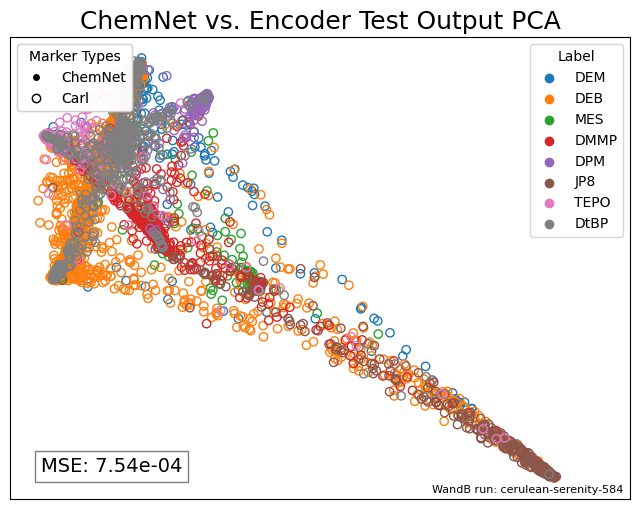

-------------------------------------------
-------------------------------------------
Dataset:  carls
Target Embeddings:  ChemNet
-------------------------------------------
-------------------------------------------
Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=1676, out_features=1548, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=1548, out_features=1420, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=1420, out_features=1292, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=1292, out_features=1164, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=1164, out_features=1036, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=1036, out_features=908, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=908, out

wandb:                                                                                


wandb: 
wandb: Run history:
wandb:         Early Stopping Ecoch ▁
wandb:        Encoder Training Loss ▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      Encoder Validation Loss ▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: Learning Rate at Final Epoch ▁
wandb: 
wandb: Run summary:
wandb:         Early Stopping Ecoch 54
wandb:        Encoder Training Loss 0.0
wandb:      Encoder Validation Loss 0.00028
wandb: Learning Rate at Final Epoch 0.0
wandb: 


wandb: 🚀 View run cerulean-serenity-584 at: https://wandb.ai/catemerfeld/ims_encoder_decoder/runs/eu0pxby7
wandb: ⭐️ View project at: https://wandb.ai/catemerfeld/ims_encoder_decoder
wandb: Synced 6 W&B file(s), 2 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20250204_082411-eu0pxby7/logs


wandb: wandb version 0.19.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.17.0


wandb: Run data is saved locally in /home/cmdunham/ChemicalDataGeneration/models/wandb/run-20250204_085335-gj5z26qm
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run neat-bush-585


wandb: ⭐️ View project at https://wandb.ai/catemerfeld/ims_encoder_decoder


wandb: 🚀 View run at https://wandb.ai/catemerfeld/ims_encoder_decoder/runs/gj5z26qm


Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  32
epochs  :  500
learning_rate  :  1e-05


Model best validation loss at 1
Epoch[1/500]:
   Training loss: 0.0025627358622351258
   Validation loss: 0.0023368622209784667
-------------------------------------------


Model best validation loss at 2


Model best validation loss at 4


Model best validation loss at 5


Model best validation loss at 9


Epoch[10/500]:
   Training loss: 2.074211065363557e-05
   Validation loss: 0.0011093751556122276
-------------------------------------------


Model best validation loss at 11


Model best validation loss at 15


Model best validation loss at 18


Epoch[20/500]:
   Training loss: 1.0306356343561406e-05
   Validation loss: 0.0009433461150863283
-------------------------------------------


Model best validation loss at 21


Model best validation loss at 22


Model best validation loss at 23


Model best validation loss at 25


Epoch[30/500]:
   Training loss: 8.10292562821887e-06
   Validation loss: 0.0007929619481222866
-------------------------------------------


Epoch 00031: reducing learning rate of group 0 to 1.0000e-06.


Epoch 00037: reducing learning rate of group 0 to 1.0000e-07.


Epoch[40/500]:
   Training loss: 1.3766008510476121e-07
   Validation loss: 0.000595147112181387
-------------------------------------------
Validation loss has not improved in 15 epochs. Stopping training at epoch 41.


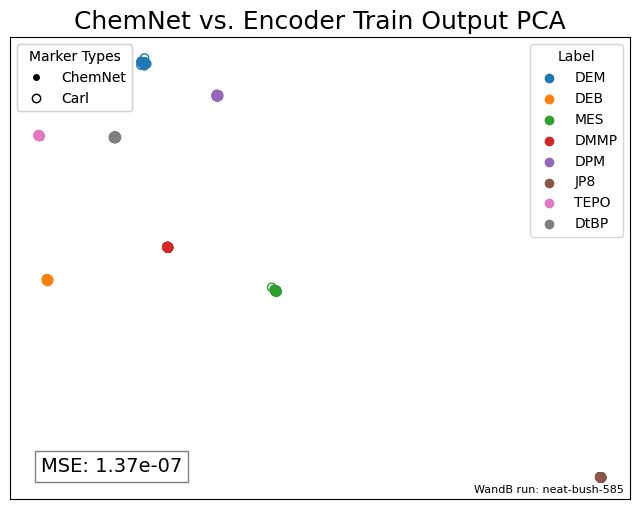

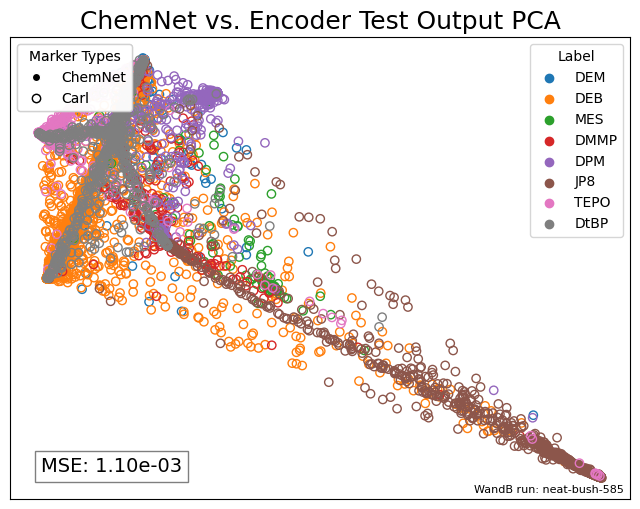

-------------------------------------------
-------------------------------------------
Dataset:  carls
Target Embeddings:  ChemNet
-------------------------------------------
-------------------------------------------
Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=1676, out_features=1548, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=1548, out_features=1420, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=1420, out_features=1292, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=1292, out_features=1164, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=1164, out_features=1036, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=1036, out_features=908, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=908, out

wandb:                                                                                


wandb: 
wandb: Run history:
wandb:         Early Stopping Ecoch ▁
wandb:        Encoder Training Loss █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      Encoder Validation Loss █▆▆▃▃▅▄▅▃▃▂▃▄▃▂▂▃▂▂▃▂▁▁▁▁▂▂▃▂▂▃▁▁▁▁▁▁▁▁▁
wandb: Learning Rate at Final Epoch ▁
wandb: 
wandb: Run summary:
wandb:         Early Stopping Ecoch 41
wandb:        Encoder Training Loss 0.0
wandb:      Encoder Validation Loss 0.0006
wandb: Learning Rate at Final Epoch 0.0
wandb: 


wandb: 🚀 View run neat-bush-585 at: https://wandb.ai/catemerfeld/ims_encoder_decoder/runs/gj5z26qm
wandb: ⭐️ View project at: https://wandb.ai/catemerfeld/ims_encoder_decoder
wandb: Synced 6 W&B file(s), 2 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20250204_085335-gj5z26qm/logs


Hyperparameters for best model: 
    batch_size  :  32
    epochs  :  500
    learning_rate  :  0.0001


In [16]:
early_stopping_threshold = 20
wandb_kwargs = {
    'architecture': architecture,
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset': dataset_type,
    'target_embedding': target_embedding,
    'early stopping threshold':early_stopping_threshold
}

# sorted_chem_names = list(train_carls.columns[-8:])

model_hyperparams = {
  'batch_size':[32],
  'epochs': [500],
  'learning_rate':[.00001],
  }

train_data = TensorDataset(train_carl_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_carl_indices_tensor)
val_data = TensorDataset(val_carl_tensor, val_chem_encodings_tensor, val_embeddings_tensor, val_carl_indices_tensor)
test_data = TensorDataset(test_carl_tensor, test_chem_encodings_tensor, test_embeddings_tensor, test_carl_indices_tensor)

best_hyperparams = f.train_model(
    'Encoder', train_data, val_data, test_data, 
    device, config, wandb_kwargs, 
    all_true_embeddings, name_smiles_embedding_df, model_hyperparams, 
    sorted_chem_names, encoder_path, save_emb_pca_to_wandb=True, early_stop_threshold=early_stopping_threshold,
    input_type='Carl', show_wandb_run_name=True, lr_scheduler=True
    )

In [17]:
best_model = f.Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))
encoder_criterion = nn.MSELoss()
print(best_model)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=1676, out_features=1548, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=1548, out_features=1420, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=1420, out_features=1292, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=1292, out_features=1164, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=1164, out_features=1036, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=1036, out_features=908, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=908, out_features=780, bias=True)
    (13): LeakyReLU(negative_slope=0.01, inplace=True)
    (14): Linear(in_features=780, out_features=652, bias=True)
    (15): LeakyReLU(negative_slope=0.01, inplace=True)
    (16): Linear(in_f

In [18]:
encoder_path = '../models/best_carl_to_chemnet_encoder.pth'
torch.save(best_model.state_dict(), encoder_path)

## Generating Carl Embedding Predictions:
---

In [19]:
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_avg_backgrounds.csv'
# train_carls = pd.read_csv(file_path)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_avg_backgrounds.csv'
# val_carls = pd.read_csv(file_path)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_avg_backgrounds.csv'
# test_carls = pd.read_csv(file_path)

# train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors(train_carls, name_smiles_embedding_df, device, carl=True)
# val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors(val_carls, name_smiles_embedding_df, device, carl=True)
# test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors(test_carls, name_smiles_embedding_df, device, carl=True)

In [20]:
# encoder_path = '../models/carl_to_chemnet_encoder_used_for_results.pth'
encoder_path = '../models/best_carl_to_chemnet_encoder.pth'
best_model = f.Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path, map_location='cuda:0'))
encoder_criterion = nn.MSELoss()

In [21]:
# batch_size = best_hyperparams['batch_size']
batch_size = 32

train_dataset = DataLoader(
    TensorDataset(
        train_carl_tensor, 
        train_chem_encodings_tensor, 
        train_embeddings_tensor,
        train_carl_indices_tensor
        ), 
        batch_size=batch_size, 
        shuffle=False
        )
predicted_embeddings, output_name_encodings, average_loss, input_carl_indices = f.predict_embeddings(train_dataset, best_model, device, encoder_criterion)
# input_carl_indices = [idx.cpu().detach().numpy() for idx_list in input_carl_indices for idx in idx_list]
input_carl_indices = [idx for idx_list in input_carl_indices for idx in idx_list]
# predicted_embeddings = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
predicted_embeddings = [emb for emb_list in predicted_embeddings for emb in emb_list]
# output_name_encodings = [enc.cpu().detach().numpy() for enc_list in output_name_encodings for enc in enc_list]
output_name_encodings = [enc for enc_list in output_name_encodings for enc in enc_list]
train_preds_df = pd.DataFrame(predicted_embeddings)
train_preds_df.insert(0, 'index', input_carl_indices)
name_encodings_df = pd.DataFrame(output_name_encodings)
# name_encodings_df.columns = train_carls.columns[-8:]
name_encodings_df.columns = sorted_chem_names
train_preds_df = pd.concat([train_preds_df, name_encodings_df], axis=1)

In [22]:
# batch_size = best_hyperparams['batch_size']
batch_size = 32

val_dataset = DataLoader(
    TensorDataset(
        val_carl_tensor, 
        val_chem_encodings_tensor, 
        val_embeddings_tensor,
        val_carl_indices_tensor
        ), 
        batch_size=batch_size, 
        shuffle=False
        )
predicted_embeddings, output_name_encodings, average_loss, input_carl_indices = f.predict_embeddings(val_dataset, best_model, device, encoder_criterion)
# input_carl_indices = [idx.cpu().detach().numpy() for idx_list in input_carl_indices for idx in idx_list]
input_carl_indices = [idx for idx_list in input_carl_indices for idx in idx_list]
# predicted_embeddings = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
predicted_embeddings = [emb for emb_list in predicted_embeddings for emb in emb_list]
# output_name_encodings = [enc.cpu().detach().numpy() for enc_list in output_name_encodings for enc in enc_list]
output_name_encodings = [enc for enc_list in output_name_encodings for enc in enc_list]
val_preds_df = pd.DataFrame(predicted_embeddings)
val_preds_df.insert(0, 'index', input_carl_indices)
name_encodings_df = pd.DataFrame(output_name_encodings)
# name_encodings_df.columns = val_carls.columns[-8:]
name_encodings_df.columns = sorted_chem_names
val_preds_df = pd.concat([val_preds_df, name_encodings_df], axis=1)

In [23]:
# batch_size = best_hyperparams['batch_size']
batch_size = 32

test_dataset = DataLoader(
    TensorDataset(
        test_carl_tensor, 
        test_chem_encodings_tensor, 
        test_embeddings_tensor,
        test_carl_indices_tensor
        ), 
        batch_size=best_hyperparams['batch_size'], 
        shuffle=False
        )
predicted_embeddings, output_name_encodings, average_loss, input_carl_indices = f.predict_embeddings(test_dataset, best_model, device, encoder_criterion)
# input_carl_indices = [idx.cpu().detach().numpy() for idx_list in input_carl_indices for idx in idx_list]
input_carl_indices = [idx for idx_list in input_carl_indices for idx in idx_list]
# predicted_embeddings = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
predicted_embeddings = [emb for emb_list in predicted_embeddings for emb in emb_list]
# output_name_encodings = [enc.cpu().detach().numpy() for enc_list in output_name_encodings for enc in enc_list]
output_name_encodings = [enc for enc_list in output_name_encodings for enc in enc_list]
test_preds_df = pd.DataFrame(predicted_embeddings)
test_preds_df.insert(0, 'index', input_carl_indices)
name_encodings_df = pd.DataFrame(output_name_encodings)
# name_encodings_df.columns = val_carls.columns[-8:]
name_encodings_df.columns = sorted_chem_names
test_preds_df = pd.concat([test_preds_df, name_encodings_df], axis=1)

In [24]:
file_path = '../data/encoder_embedding_predictions/train_preds.csv'
train_preds_df.to_csv(file_path, index=False)
file_path = '../data/encoder_embedding_predictions/val_preds.csv'
val_preds_df.to_csv(file_path, index=False)
file_path = '../data/encoder_embedding_predictions/test_preds.csv'
test_preds_df.to_csv(file_path, index=False)

In [25]:
encoder_path = 'trained_models/carl_to_chemnet_encoder_used_for_results.pth'
torch.save(best_model.state_dict(), encoder_path)

## Viewing Encoder Results:
---

In [26]:
# # sorted_chem_names = list(train_carls.columns[-8:])

# # train_data = TensorDataset(train_carl_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_carl_indices_tensor)

# # # batch_size = best_hyperparams['batch_size']
# # batch_size = 32

# f.plot_pca(
#     train_data, batch_size, best_model, device, 
#     encoder_criterion, sorted_chem_names, all_true_embeddings, 
#     name_smiles_embedding_df, 'Train', input_type='IMS', show_wandb_run_name = False, log_wandb=False
#     )

In [27]:
# sorted_chem_names = list(val_carls.columns[-8:])

# val_data = TensorDataset(val_carl_tensor, val_chem_encodings_tensor, val_embeddings_tensor, val_carl_indices_tensor)

# # batch_size = best_hyperparams['batch_size']
# batch_size = 32

# f.plot_pca(
#     val_data, batch_size, best_model, device, 
#     encoder_criterion, sorted_chem_names, all_true_embeddings, 
#     name_smiles_embedding_df, 'Validation', input_type='IMS', show_wandb_run_name = False, log_wandb=False
#     )

In [28]:
# sorted_chem_names = list(test_carls.columns[-8:])

# test_data = TensorDataset(test_carl_tensor, test_chem_encodings_tensor, test_embeddings_tensor, test_carl_indices_tensor)

# # batch_size = best_hyperparams['batch_size']
# batch_size = 32

# f.plot_pca(
#     test_data, batch_size, best_model, device, 
#     encoder_criterion, sorted_chem_names, all_true_embeddings, 
#     name_smiles_embedding_df, 'Test', input_type='IMS', show_wandb_run_name = False, log_wandb=False
#     )